In [3]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import dask.dataframe as dd
import dask.bag as db
from dask.diagnostics import ProgressBar


In [4]:
# read the csv file and extract the title column as a Dask DataFrame
df = dd.read_csv("Heart_disease.csv")
titles = df['Title']

In [5]:
# define a function to preprocess the titles
def preprocess(title):
    # remove any non-alphabetical characters
    title = re.sub('[^a-zA-Z]', ' ', title)
    # convert all characters to lowercase
    title = title.lower()
    # remove stopwords
    title = ' '.join([word for word in title.split() if word not in stopwords.words('english')])
    # replace multiple spaces with a single space
    title = re.sub(' +', ' ', title)
    return title

In [6]:
# preprocess the titles using Dask Bag
titles_bag = db.from_sequence(titles, npartitions=4)
preprocessed_titles_bag = titles_bag.map(preprocess)

In [7]:
# convert the preprocessed titles back to a Dask DataFrame
preprocessed_titles = preprocessed_titles_bag.to_dataframe(meta={'Preprocessed Title': str})

In [8]:
# Create a Dask DataFrame to work with the preprocessed titles
preprocessed_df = preprocessed_titles

In [9]:
# Create a TfidfVectorizer object to transform the preprocessed titles into a Dask array
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(preprocessed_df['Preprocessed Title'])

In [10]:
# Use KMeans clustering to group the preprocessed titles into clusters
kmeans = KMeans(n_clusters=16, random_state=0).fit(X)

C:\Users\mud_o\anaconda3\envs\cashi\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
# Print the top terms for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()


In [12]:
with ProgressBar():
    for i in range(kmeans.n_clusters):
        print(f"Cluster {i} top terms:")
        for j in order_centroids[i, :5]:
            print(f"    {terms[j]}")
        print()

Cluster 0 top terms:
    ca
    sup
    kinase
    sub
    protein

Cluster 1 top terms:
    myocardial infarction
    infarction
    myocardial
    acute myocardial
    acute

Cluster 2 top terms:
    atherosclerosis
    study
    study atherosclerosis
    ethnic
    multi ethnic

Cluster 3 top terms:
    cells
    endothelial cells
    endothelial
    stem
    stem cells

Cluster 4 top terms:
    magnetic resonance
    resonance
    magnetic
    resonance imaging
    imaging

Cluster 5 top terms:
    cardiac
    cardiac arrest
    arrest
    hypertrophy
    cardiac hypertrophy

Cluster 6 top terms:
    cell
    endothelial
    endothelial cell
    factor
    growth

Cluster 7 top terms:
    coronary
    disease
    coronary artery
    artery
    heart disease

Cluster 8 top terms:
    induced
    heart
    mice
    vascular
    pulmonary

Cluster 9 top terms:
    nitric
    nitric oxide
    oxide
    oxide synthase
    synthase

Cluster 10 top terms:
    reperfusion
    ischemia repe

In [13]:
from sklearn.metrics import silhouette_score
# calculate silhouette score
silhouette_avg = silhouette_score(X, kmeans.labels_)

In [14]:
# print the silhouette score
print(f"The average silhouette score is: {silhouette_avg:.3f}")

The average silhouette score is: 0.004


In [37]:
from sklearn.manifold import TSNE
import numpy as np

# Select a random subset of rows from the preprocessed DataFrame
sample_fraction = 0.01
sampled_df = preprocessed_df.sample(frac=sample_fraction, random_state=0).compute()


# Extract the corresponding subset of feature vectors from the sparse matrix
sampled_indices = np.array(sampled_df.index)
X_sampled = X[sampled_indices, :]

# Apply t-SNE to the subset of data
X_tsne = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(X_sampled.toarray())


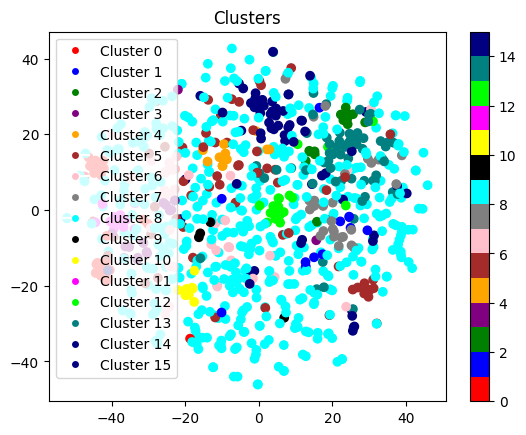

In [43]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a custom colormap with a unique color for each cluster
cmap = ListedColormap(['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'black', 'yellow', 'magenta', 'lime', 'teal', 'navy'])
# Assign labels to each point based on their cluster assignment
labels = kmeans.labels_

# Create a scatter plot with different colors for each cluster
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels[sampled_indices], cmap=cmap)
plt.colorbar()
# Add a legend to the plot
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
                               markerfacecolor=cmap(i)) for i in np.unique(labels)]
plt.legend(handles=legend_elements)
plt.title('Clusters')
plt.show()


In [ ]:
# Print the cluster assignments for each article title
pairings = {}
for i in range(len(preprocessed_df)):
    label = kmeans.labels_[i]
    topic = terms[order_centroids[label, 0]]
    pairings[preprocessed_df.loc[i, 'Preprocessed Title']] = topic
df['Topic'] = df['Title'].map(pairings)

In [ ]:
# save the dataframe to a csv file
df.to_csv('Heart_disease_with_topics.csv', index=False)
